In [1]:
!pip uninstall -y scikit-learn xgboost
!pip install -q scikit-learn==1.5.2 xgboost==1.7.4

Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: xgboost 2.1.3
Uninstalling xgboost-2.1.3:
  Successfully uninstalled xgboost-2.1.3



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os
import ast
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# **1. Reviewing the dataset**

In [7]:
df = pd.read_csv('dataset/training_data.csv')
df.head()

,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,job_simplified,seniority,Rating Category,job_state,Python_yn,Spark,AWS_yn,Average Salary
0,Tecolote Research,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),data scientist,Other,Medium Rating,NM,1,0,0,7.200e+04
1,University of Maryland Medical System,"Linthicum, MD","Baltimore, MD",10000+ employees,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),data scientist,Other,Medium Rating,MD,1,0,0,8.750e+04
2,KnowBe4,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),data scientist,Other,High Rating,FL,1,1,0,8.500e+04
3,PNNL,"Richland, WA","Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),data scientist,Other,Medium Rating,WA,1,0,0,7.650e+04
4,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown,data scientist,Other,Low Rating,NY,1,0,0,1.145e+05


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company Name       742 non-null    object 
 1   Location           742 non-null    object 
 2   Headquarters       742 non-null    object 
 3   Size               742 non-null    object 
 4   Type of ownership  742 non-null    object 
 5   Industry           742 non-null    object 
 6   Sector             742 non-null    object 
 7   Revenue            742 non-null    object 
 8   job_simplified     742 non-null    object 
 9   seniority          742 non-null    object 
 10  Rating Category    742 non-null    object 
 11  job_state          742 non-null    object 
 12  Python_yn          742 non-null    int64  
 13  Spark              742 non-null    int64  
 14  AWS_yn             742 non-null    int64  
 15  Average Salary     742 non-null    float64
dtypes: float64(1), int64(3), o

In [9]:
df.describe()

,Python_yn,Spark,AWS_yn,Average Salary
count,7.420e+02,7.420e+02,7.420e+02,7.420e+02
mean,5.283e-01,2.251e-01,2.372e-01,1.015e+05
std,4.995e-01,4.179e-01,4.257e-01,3.746e+04
min,0.000e+00,0.000e+00,0.000e+00,1.550e+04
25%,0.000e+00,0.000e+00,0.000e+00,7.350e+04
50%,1.000e+00,0.000e+00,0.000e+00,9.750e+04
75%,1.000e+00,0.000e+00,0.000e+00,1.225e+05
max,1.000e+00,1.000e+00,1.000e+00,2.540e+05


In [10]:
df[df.duplicated()]

,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,job_simplified,seniority,Rating Category,job_state,Python_yn,Spark,AWS_yn,Average Salary
29,KnowBe4,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,Company - Private,Security Services,Business Services,$100 to $500 million (USD),data scientist,Other,High Rating,FL,1,1,0,8.500e+04
30,PNNL,"Richland, WA","Richland, WA",1001 to 5000 employees,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),data scientist,Other,Medium Rating,WA,1,0,0,7.650e+04
58,ClearOne Advantage,"Baltimore, MD","Baltimore, MD",501 to 1000 employees,Company - Private,Banks & Credit Unions,Finance,Unknown,data scientist,Other,High Rating,MD,0,0,0,7.350e+04
59,CyrusOne,"Dallas, TX","Dallas, TX",201 to 500 employees,Company - Public,Real Estate,Real Estate,$1 to $2 billion (USD),data scientist,Other,Medium Rating,TX,1,0,1,9.500e+04
86,Walmart,"Plano, TX","Bentonville, AR",10000+ employees,Company - Public,"Department, Clothing, & Shoe Stores",Retail,$10+ billion (USD),data scientist,Associate,Medium Rating,TX,0,0,0,1.390e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737,GSK,"Cambridge, MA","Brentford, United Kingdom",10000+ employees,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),other scientist,Senior/Principal,Medium Rating,MA,0,0,1,8.450e+04
738,Eventbrite,"Nashville, TN","San Francisco, CA",1001 to 5000 employees,Company - Public,Internet,Information Technology,$100 to $500 million (USD),data engineer,Senior/Principal,High Rating,TN,1,1,1,1.025e+05
739,Software Engineering Institute,"Pittsburgh, PA","Pittsburgh, PA",501 to 1000 employees,College / University,Colleges & Universities,Education,Unknown,other scientist,Entry Level,Low Rating,PA,0,0,0,7.350e+04
740,"Numeric, LLC","Allentown, PA","Chadds Ford, PA",1 to 50 employees,Company - Private,Staffing & Outsourcing,Business Services,$5 to $10 million (USD),data scientist,Senior/Principal,Medium Rating,PA,0,0,0,1.275e+05


# **2. Train - Test Split**

In [12]:
X = df.drop('Average Salary', axis=1)
y = df['Average Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (593, 15)
y_train shape: (593,)
X_test shape: (149, 15)
y_test shape: (149,)


# **3. Modeling**

In [15]:
def create_pipeline(model_name):
    regression_models = {
        'SVR': SVR(),
        'XGBoost': XGBRegressor(random_state=42),
        'KNeighbors': KNeighborsRegressor(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42),
        'LinearRegression': LinearRegression(),
    }

    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numerical_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Sửa đổi OneHotEncoder để tạo ra đầu ra dense
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', regression_models[model_name])
    ])

    pipeline_dict = {model_name: pipeline}
    return pipeline_dict

def create_all_pipelines():
    regression_model_names = [
        'RandomForest', 'SVR', 'LinearRegression',
        'KNeighbors', 'DecisionTree', 'XGBoost'
    ]

    all_pipelines = {}
    for model_name in regression_model_names:
        pipeline_dict = create_pipeline(model_name)
        all_pipelines.update(pipeline_dict)
        
    return all_pipelines

def train_evaluate_model(model_name, model, X_train, y_train, X_test, y_test, results_df):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results = pd.DataFrame({
        'Model': [model_name], 
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2
    })
    results_df = pd.concat([results_df, model_results], ignore_index=True)

    return results_df

def run_pipelines_with_metrics(all_pipelines, X_train, y_train, X_test, y_test):
    results_df = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'R2'])

    for model_name, pipeline in all_pipelines.items():
        results_df = train_evaluate_model(
            model_name, pipeline, 
            X_train, y_train, X_test, y_test, 
            results_df
        )

    results_df = results_df.sort_values(
        by='R2', 
        ascending=False
    ).reset_index(drop=True)

    return results_df

In [16]:
all_pipelines = create_all_pipelines()
results_df    = run_pipelines_with_metrics(all_pipelines, X_train, y_train, X_test, y_test)
results_df

C:\Users\Acer\AppData\Local\Temp\ipykernel_17920\1920717257.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, model_results], ignore_index=True)
c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


,Model,MSE,MAE,R2
0,XGBoost,2.687e+08,1.065e+04,8.286e-01
1,RandomForest,2.936e+08,1.127e+04,8.127e-01
2,DecisionTree,4.605e+08,1.024e+04,7.062e-01
3,KNeighbors,7.917e+08,2.099e+04,4.950e-01
4,SVR,1.616e+09,3.117e+04,-3.078e-02
5,LinearRegression,1.225e+30,4.258e+14,-7.812e+20


**Remarks**: Among the selected models, XGBoost demonstrates the best performance, so I choose this model to proceed with the next steps.

# **4. Run XBG with default params**

In [17]:
xgb_res = XGBRegressor()

default_params = xgb_res.get_params()

desired_params          = ['reg_lambda', 'reg_alpha', 'n_estimators', 'max_depth', 'learning_rate', 'gamma', 'colsample_bytree']
selected_default_params = {param: default_params[param] for param in desired_params}

default_params_df = pd.DataFrame([selected_default_params])
default_params_df = default_params_df.transpose()
default_params_df.columns = ['Value']

print("XGB's default params:")
default_params_df

XGB's default params:


,Value
reg_lambda,None
reg_alpha,None
n_estimators,100
max_depth,None
learning_rate,None
gamma,None
colsample_bytree,None


In [18]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # Sửa đổi OneHotEncoder để tạo ra đầu ra dense
    ]
)

xgb_res = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

xgb_res.fit(X_train, y_train)
y_pred = xgb_res.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 268723315.569
Mean Absolute Error (MAE): 10650.671
R-squared (R2) Score: 0.829


# **5. Tuning**

In [19]:
params = {
    "n_estimators": range(100, 500, 50),
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],
    "max_depth": range(3, 21, 3),
    "gamma": [i / 10.0 for i in range(0, 5)],
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}
rs = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',RandomizedSearchCV(XGBRegressor(),params,n_iter=50,verbose=3,random_state=42))
])
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-8.627 total time=   1.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-6.897 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-5.408 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-8.500 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-7.010 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.505 total time=   3.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.758 total time=   3.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.564 total time=   3.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.707 total time=   3.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;, score=0.613 total time=   3.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=100, reg_alpha=10, reg_lambda=10;, score=-7.487 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=100, reg_alpha=10, reg_lambda=10;, score=-5.953 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=100, reg_alpha=10, reg_lambda=10;, score=-4.639 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=100, reg_alpha=10, reg_lambda=10;, score=-7.349 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=100, reg_alpha=10, reg_lambda=10;, score=-6.069 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=0.1, reg_lambda=0.1;, score=0.516 total time=   4.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=0.1, reg_lambda=0.1;, score=0.713 total time=   4.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=0.1, reg_lambda=0.1;, score=0.642 total time=   4.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=0.1, reg_lambda=0.1;, score=0.567 total time=   3.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=0.1, reg_lambda=0.1;, score=0.637 total time=   3.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=1, max_depth=9, n_estimators=150, reg_alpha=100, reg_lambda=100;, score=0.586 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=1, max_depth=9, n_estimators=150, reg_alpha=100, reg_lambda=100;, score=0.760 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=1, max_depth=9, n_estimators=150, reg_alpha=100, reg_lambda=100;, score=0.615 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=1, max_depth=9, n_estimators=150, reg_alpha=100, reg_lambda=100;, score=0.684 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=1, max_depth=9, n_estimators=150, reg_alpha=100, reg_lambda=100;, score=0.618 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=450, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.717 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=450, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.760 total time=   2.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=450, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.626 total time=   2.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=450, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.739 total time=   2.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=450, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.745 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=6, n_estimators=400, reg_alpha=10, reg_lambda=10;, score=-8.417 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=6, n_estimators=400, reg_alpha=10, reg_lambda=10;, score=-6.712 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=6, n_estimators=400, reg_alpha=10, reg_lambda=10;, score=-5.262 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=6, n_estimators=400, reg_alpha=10, reg_lambda=10;, score=-8.284 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=6, n_estimators=400, reg_alpha=10, reg_lambda=10;, score=-6.841 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=300, reg_alpha=1, reg_lambda=10;, score=-5.059 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=300, reg_alpha=1, reg_lambda=10;, score=-3.982 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=300, reg_alpha=1, reg_lambda=10;, score=-3.026 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=300, reg_alpha=1, reg_lambda=10;, score=-4.916 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=300, reg_alpha=1, reg_lambda=10;, score=-4.063 total time=   1.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=1, max_depth=9, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=0.489 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=1, max_depth=9, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=0.719 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=1, max_depth=9, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=0.635 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=1, max_depth=9, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=0.506 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=1, max_depth=9, n_estimators=400, reg_alpha=100, reg_lambda=1;, score=0.534 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1e-05;, score=-8.353 total time=   2.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1e-05;, score=-6.679 total time=   2.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1e-05;, score=-5.223 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1e-05;, score=-8.228 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=400, reg_alpha=1, reg_lambda=1e-05;, score=-6.782 total time=   2.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-6.028 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-4.772 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-3.684 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-5.859 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.001, max_depth=9, n_estimators=200, reg_alpha=10, reg_lambda=1;, score=-4.793 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.0001, max_depth=15, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-8.710 total time=   1.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.0001, max_depth=15, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-6.965 total time=   1.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.0001, max_depth=15, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-5.464 total time=   2.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.0001, max_depth=15, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-8.582 total time=   1.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.0001, max_depth=15, n_estimators=200, reg_alpha=100, reg_lambda=0.01;, score=-7.081 total time=   1.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.0001, max_depth=18, n_estimators=400, reg_alpha=100, reg_lambda=0.01;, score=-8.338 total time=   5.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.0001, max_depth=18, n_estimators=400, reg_alpha=100, reg_lambda=0.01;, score=-6.662 total time=   5.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.0001, max_depth=18, n_estimators=400, reg_alpha=100, reg_lambda=0.01;, score=-5.213 total time=   5.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.0001, max_depth=18, n_estimators=400, reg_alpha=100, reg_lambda=0.01;, score=-8.208 total time=   4.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.9, gamma=0.2, learning_rate=0.0001, max_depth=18, n_estimators=400, reg_alpha=100, reg_lambda=0.01;, score=-6.774 total time=   4.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=15, n_estimators=350, reg_alpha=0.1, reg_lambda=0.1;, score=0.685 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=15, n_estimators=350, reg_alpha=0.1, reg_lambda=0.1;, score=0.728 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=15, n_estimators=350, reg_alpha=0.1, reg_lambda=0.1;, score=0.674 total time=   1.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=15, n_estimators=350, reg_alpha=0.1, reg_lambda=0.1;, score=0.721 total time=   1.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=0.1, max_depth=15, n_estimators=350, reg_alpha=0.1, reg_lambda=0.1;, score=0.745 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.01, max_depth=12, n_estimators=100, reg_alpha=1, reg_lambda=0.1;, score=-0.707 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.01, max_depth=12, n_estimators=100, reg_alpha=1, reg_lambda=0.1;, score=-0.482 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.01, max_depth=12, n_estimators=100, reg_alpha=1, reg_lambda=0.1;, score=-0.169 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.01, max_depth=12, n_estimators=100, reg_alpha=1, reg_lambda=0.1;, score=-0.598 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.01, max_depth=12, n_estimators=100, reg_alpha=1, reg_lambda=0.1;, score=-0.366 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=450, reg_alpha=1e-05, reg_lambda=100;, score=0.307 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=450, reg_alpha=1e-05, reg_lambda=100;, score=0.451 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=450, reg_alpha=1e-05, reg_lambda=100;, score=0.437 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=450, reg_alpha=1e-05, reg_lambda=100;, score=0.481 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=0.01, max_depth=3, n_estimators=450, reg_alpha=1e-05, reg_lambda=100;, score=0.470 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=100;, score=0.249 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=100;, score=0.402 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=100;, score=0.409 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=100;, score=0.426 total time=   1.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, max_depth=6, n_estimators=350, reg_alpha=1, reg_lambda=100;, score=0.410 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=250, reg_alpha=10, reg_lambda=0.01;, score=-5.352 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=250, reg_alpha=10, reg_lambda=0.01;, score=-4.224 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=250, reg_alpha=10, reg_lambda=0.01;, score=-3.187 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=250, reg_alpha=10, reg_lambda=0.01;, score=-5.201 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=250, reg_alpha=10, reg_lambda=0.01;, score=-4.264 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.0001, max_depth=6, n_estimators=100, reg_alpha=100, reg_lambda=1;, score=-8.911 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.0001, max_depth=6, n_estimators=100, reg_alpha=100, reg_lambda=1;, score=-7.124 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.0001, max_depth=6, n_estimators=100, reg_alpha=100, reg_lambda=1;, score=-5.598 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.0001, max_depth=6, n_estimators=100, reg_alpha=100, reg_lambda=1;, score=-8.782 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.0001, max_depth=6, n_estimators=100, reg_alpha=100, reg_lambda=1;, score=-7.247 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=350, reg_alpha=0.01, reg_lambda=100;, score=0.583 total time=   3.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=350, reg_alpha=0.01, reg_lambda=100;, score=0.804 total time=   3.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=350, reg_alpha=0.01, reg_lambda=100;, score=0.596 total time=   3.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=350, reg_alpha=0.01, reg_lambda=100;, score=0.650 total time=   3.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.9, gamma=0.0, learning_rate=1, max_depth=15, n_estimators=350, reg_alpha=0.01, reg_lambda=100;, score=0.633 total time=   3.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=1, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=100;, score=0.528 total time=   2.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=1, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=100;, score=0.736 total time=   2.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=1, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=100;, score=0.586 total time=   2.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=1, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=100;, score=0.708 total time=   2.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=1, max_depth=15, n_estimators=400, reg_alpha=100, reg_lambda=100;, score=0.602 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, n_estimators=350, reg_alpha=100, reg_lambda=0.1;, score=-4.227 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, n_estimators=350, reg_alpha=100, reg_lambda=0.1;, score=-3.356 total time=   2.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, n_estimators=350, reg_alpha=100, reg_lambda=0.1;, score=-2.448 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, n_estimators=350, reg_alpha=100, reg_lambda=0.1;, score=-4.106 total time=   2.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.001, max_depth=9, n_estimators=350, reg_alpha=100, reg_lambda=0.1;, score=-3.326 total time=   2.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=350, reg_alpha=0.1, reg_lambda=1e-05;, score=0.660 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=350, reg_alpha=0.1, reg_lambda=1e-05;, score=0.734 total time=   2.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=350, reg_alpha=0.1, reg_lambda=1e-05;, score=0.573 total time=   3.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=350, reg_alpha=0.1, reg_lambda=1e-05;, score=0.738 total time=   3.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=350, reg_alpha=0.1, reg_lambda=1e-05;, score=0.765 total time=   3.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=18, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=-4.873 total time=   1.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=18, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=-3.831 total time=   2.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=18, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=-2.925 total time=   1.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=18, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=-4.688 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=18, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=-3.813 total time=   1.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=15, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=0.424 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=15, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=0.705 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=15, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=0.454 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=15, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=0.462 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=1, max_depth=15, n_estimators=300, reg_alpha=10, reg_lambda=1;, score=0.552 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.0001, max_depth=15, n_estimators=150, reg_alpha=1, reg_lambda=10;, score=-8.831 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.0001, max_depth=15, n_estimators=150, reg_alpha=1, reg_lambda=10;, score=-7.057 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.0001, max_depth=15, n_estimators=150, reg_alpha=1, reg_lambda=10;, score=-5.545 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.0001, max_depth=15, n_estimators=150, reg_alpha=1, reg_lambda=10;, score=-8.703 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.3, learning_rate=0.0001, max_depth=15, n_estimators=150, reg_alpha=1, reg_lambda=10;, score=-7.185 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=12, n_estimators=100, reg_alpha=100, reg_lambda=0.01;, score=-7.337 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=12, n_estimators=100, reg_alpha=100, reg_lambda=0.01;, score=-5.867 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=12, n_estimators=100, reg_alpha=100, reg_lambda=0.01;, score=-4.544 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=12, n_estimators=100, reg_alpha=100, reg_lambda=0.01;, score=-7.215 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.2, learning_rate=0.001, max_depth=12, n_estimators=100, reg_alpha=100, reg_lambda=0.01;, score=-5.930 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=150, reg_alpha=1, reg_lambda=100;, score=-8.876 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=150, reg_alpha=1, reg_lambda=100;, score=-7.094 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=150, reg_alpha=1, reg_lambda=100;, score=-5.571 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=150, reg_alpha=1, reg_lambda=100;, score=-8.749 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=12, n_estimators=150, reg_alpha=1, reg_lambda=100;, score=-7.221 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=12, n_estimators=300, reg_alpha=0.01, reg_lambda=100;, score=-5.612 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=12, n_estimators=300, reg_alpha=0.01, reg_lambda=100;, score=-4.421 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=12, n_estimators=300, reg_alpha=0.01, reg_lambda=100;, score=-3.358 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=12, n_estimators=300, reg_alpha=0.01, reg_lambda=100;, score=-5.480 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.001, max_depth=12, n_estimators=300, reg_alpha=0.01, reg_lambda=100;, score=-4.516 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=1;, score=-7.416 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=1;, score=-5.910 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=1;, score=-4.604 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=1;, score=-7.271 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=1;, score=-5.981 total time=   0.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=10, reg_lambda=0.01;, score=0.587 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=10, reg_lambda=0.01;, score=0.706 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=10, reg_lambda=0.01;, score=0.595 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=10, reg_lambda=0.01;, score=0.662 total time=   0.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.1, max_depth=3, n_estimators=150, reg_alpha=10, reg_lambda=0.01;, score=0.684 total time=   0.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1;, score=-8.733 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1;, score=-6.980 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1;, score=-5.479 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1;, score=-8.602 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.0, learning_rate=0.0001, max_depth=6, n_estimators=200, reg_alpha=1, reg_lambda=1;, score=-7.096 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=1e-05;, score=0.695 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=1e-05;, score=0.763 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=1e-05;, score=0.657 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=1e-05;, score=0.731 total time=   3.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=1e-05;, score=0.787 total time=   2.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=0.01;, score=0.650 total time=   0.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=0.01;, score=0.773 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=0.01;, score=0.449 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=0.01;, score=0.655 total time=   0.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=3, n_estimators=150, reg_alpha=0.01, reg_lambda=0.01;, score=0.666 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=300, reg_alpha=0.1, reg_lambda=1;, score=0.690 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=300, reg_alpha=0.1, reg_lambda=1;, score=0.756 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=300, reg_alpha=0.1, reg_lambda=1;, score=0.652 total time=   0.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=300, reg_alpha=0.1, reg_lambda=1;, score=0.726 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.1, max_depth=6, n_estimators=300, reg_alpha=0.1, reg_lambda=1;, score=0.755 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=10;, score=0.574 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=10;, score=0.767 total time=   1.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=10;, score=0.574 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=10;, score=0.711 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=10;, score=0.724 total time=   1.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=6, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.1;, score=0.555 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=6, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.1;, score=0.648 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=6, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.1;, score=0.587 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=6, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.1;, score=0.628 total time=   0.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.01, max_depth=6, n_estimators=300, reg_alpha=1e-05, reg_lambda=0.1;, score=0.669 total time=   0.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=3, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=0.567 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=3, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=0.695 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=3, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=0.532 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=3, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=0.635 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=3, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=0.582 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=400, reg_alpha=0.1, reg_lambda=10;, score=0.582 total time=   2.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=400, reg_alpha=0.1, reg_lambda=10;, score=0.819 total time=   2.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=400, reg_alpha=0.1, reg_lambda=10;, score=0.548 total time=   2.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=400, reg_alpha=0.1, reg_lambda=10;, score=0.699 total time=   2.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=400, reg_alpha=0.1, reg_lambda=10;, score=0.716 total time=   2.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1e-05, reg_lambda=1;, score=-1.041 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1e-05, reg_lambda=1;, score=-0.695 total time=   0.3s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1e-05, reg_lambda=1;, score=-0.386 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1e-05, reg_lambda=1;, score=-0.842 total time=   0.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=1e-05, reg_lambda=1;, score=-0.635 total time=   0.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=1e-05, reg_lambda=1e-05;, score=-3.714 total time=   4.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=1e-05, reg_lambda=1e-05;, score=-2.919 total time=   3.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=1e-05, reg_lambda=1e-05;, score=-2.120 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=1e-05, reg_lambda=1e-05;, score=-3.565 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.001, max_depth=15, n_estimators=400, reg_alpha=1e-05, reg_lambda=1e-05;, score=-2.903 total time=   5.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=18, n_estimators=100, reg_alpha=10, reg_lambda=1;, score=0.593 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=18, n_estimators=100, reg_alpha=10, reg_lambda=1;, score=0.787 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=18, n_estimators=100, reg_alpha=10, reg_lambda=1;, score=0.566 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=18, n_estimators=100, reg_alpha=10, reg_lambda=1;, score=0.722 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=18, n_estimators=100, reg_alpha=10, reg_lambda=1;, score=0.755 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.682 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.735 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.583 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.715 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.1, max_depth=15, n_estimators=100, reg_alpha=0.1, reg_lambda=0.01;, score=0.710 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=12, n_estimators=450, reg_alpha=1, reg_lambda=1;, score=0.648 total time=   2.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=12, n_estimators=450, reg_alpha=1, reg_lambda=1;, score=0.788 total time=   2.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=12, n_estimators=450, reg_alpha=1, reg_lambda=1;, score=0.569 total time=   2.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=12, n_estimators=450, reg_alpha=1, reg_lambda=1;, score=0.731 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1, max_depth=12, n_estimators=450, reg_alpha=1, reg_lambda=1;, score=0.770 total time=   2.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.0001, max_depth=15, n_estimators=250, reg_alpha=0.1, reg_lambda=0.01;, score=-8.616 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.0001, max_depth=15, n_estimators=250, reg_alpha=0.1, reg_lambda=0.01;, score=-6.891 total time=   1.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.0001, max_depth=15, n_estimators=250, reg_alpha=0.1, reg_lambda=0.01;, score=-5.401 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.0001, max_depth=15, n_estimators=250, reg_alpha=0.1, reg_lambda=0.01;, score=-8.488 total time=   1.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.0001, max_depth=15, n_estimators=250, reg_alpha=0.1, reg_lambda=0.01;, score=-7.003 total time=   2.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=3, n_estimators=450, reg_alpha=0.1, reg_lambda=1e-05;, score=-8.309 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=3, n_estimators=450, reg_alpha=0.1, reg_lambda=1e-05;, score=-6.625 total time=   1.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=3, n_estimators=450, reg_alpha=0.1, reg_lambda=1e-05;, score=-5.183 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=3, n_estimators=450, reg_alpha=0.1, reg_lambda=1e-05;, score=-8.163 total time=   0.8s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.0001, max_depth=3, n_estimators=450, reg_alpha=0.1, reg_lambda=1e-05;, score=-6.737 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=9, n_estimators=350, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.486 total time=   1.1s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=9, n_estimators=350, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.689 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=9, n_estimators=350, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.630 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=9, n_estimators=350, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.500 total time=   0.9s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=1, max_depth=9, n_estimators=350, reg_alpha=1e-05, reg_lambda=1e-05;, score=0.539 total time=   1.0s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=1;, score=-3.962 total time=   1.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=1;, score=-3.097 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=1;, score=-2.308 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=1;, score=-3.760 total time=   1.4s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.001, max_depth=6, n_estimators=400, reg_alpha=0.01, reg_lambda=1;, score=-3.031 total time=   1.2s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=18, n_estimators=250, reg_alpha=0.01, reg_lambda=0.01;, score=-5.245 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=18, n_estimators=250, reg_alpha=0.01, reg_lambda=0.01;, score=-4.198 total time=   1.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=18, n_estimators=250, reg_alpha=0.01, reg_lambda=0.01;, score=-3.161 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=18, n_estimators=250, reg_alpha=0.01, reg_lambda=0.01;, score=-5.124 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.001, max_depth=18, n_estimators=250, reg_alpha=0.01, reg_lambda=0.01;, score=-4.193 total time=   1.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.0001, max_depth=15, n_estimators=450, reg_alpha=100, reg_lambda=0.01;, score=-8.250 total time=   3.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.0001, max_depth=15, n_estimators=450, reg_alpha=100, reg_lambda=0.01;, score=-6.596 total time=   3.7s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.0001, max_depth=15, n_estimators=450, reg_alpha=100, reg_lambda=0.01;, score=-5.156 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 4/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.0001, max_depth=15, n_estimators=450, reg_alpha=100, reg_lambda=0.01;, score=-8.120 total time=   3.5s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 5/5] END colsample_bytree=0.8, gamma=0.4, learning_rate=0.0001, max_depth=15, n_estimators=450, reg_alpha=100, reg_lambda=0.01;, score=-6.698 total time=   3.6s


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Python_yn', 'Spark',
                                                   'AWS_yn']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Company Name', 'Location',
                                                   'Headquarters', 'Size',
                                                   'Type of ownership',
                                                   'Industry', 'Sector',
                                                   'Revenue', 'job_simplified',
                                                   'seniority',
                                                   'Rating Category',
                                                   'job_state'])])),
                ('mod...
                                                           predictor=None,
                                                           random_state=None, ...),
                                    n_iter=50,
                                    param_distributions={'colsample_bytree': [0.3,
                                                                              0.4,
                                                                              0.5,
                                                                              0.6,
                                                                              0.7,
                                                                              0.8,
                                                                              0.9],
                                                         'gamma': [0.0, 0.1,
                                                                   0.2, 0.3,
                                                                   0.4],
                                                         'learning_rate': [0.0001,
                                                                           0.001,
                                                                           0.01,
                                                                           0.1,
                                                                           1],
                                                         'max_depth': range(3, 21, 3),
                                                         'n_estimators': range(100, 500, 50),
                                                         'reg_alpha': [1e-05,
                                                                       0.01,
                                                                       0.1, 1,
                                                                       10,
                                                                       100],
                                                         'reg_lambda': [1e-05,
                                                                        0.01,
                                                                        0.1, 1,
                                                                        10,
                                                                        100]},
                                    random_state=42, verbose=3))])

In [20]:
random_search = rs.named_steps['model']
print(f'Best score: {random_search.best_score_:.3f}')

best_params_df = pd.DataFrame([random_search.best_params_]).transpose()
best_params_df.columns = ['Value']
print('Best params:')
print(best_params_df)

Best score: 0.727
Best params:
                     Value
reg_lambda       1.000e-05
reg_alpha        1.000e+00
n_estimators     4.500e+02
max_depth        1.800e+01
learning_rate    1.000e-01
gamma            4.000e-01
colsample_bytree 4.000e-01


In [32]:
random_search = rs.named_steps['model']
results_df = pd.DataFrame(random_search.cv_results_)

selected_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[selected_columns]

results_df = results_df.sort_values(by='rank_test_score')

output_dir = 'tuning'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'XGBoost_params.csv')
results_df.to_csv(output_path, index=False)

print(f"The result is saved to: {output_path}")

The result is saved to: tuning\XGBoost_params.csv


# **6. Evaluation**

## **6.1. Train - Test Split**

In [33]:
xgb_rscv = pd.read_csv("tuning\XGBoost_params.csv")
best_params = ast.literal_eval(xgb_rscv['params'][0])

xgb_best = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',XGBRegressor(**best_params))
])

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 248466344.827
Mean Absolute Error (MAE): 7420.090
R-squared (R2) Score: 0.842


## **6.2. Cross Validation (K-Fold)**

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mses = []
maes = []
r2s = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i + 1}:") 

    xgb_best.fit(X.iloc[train_index], y.iloc[train_index])
    y_pred = xgb_best.predict(X.iloc[test_index])

    mse = mean_squared_error(y.iloc[test_index], y_pred)
    mae = mean_absolute_error(y.iloc[test_index], y_pred)
    r2 = r2_score(y.iloc[test_index], y_pred)

    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared (R2) Score: {r2:.3f}")
    print()

    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

mean_mse = sum(mses) / len(mses)
mean_mae = sum(maes) / len(maes)
mean_r2 = sum(r2s) / len(r2s)

print(f"Mean MSEs: {mean_mse:.3f}")
print(f"Mean MAEs: {mean_mae:.3f}")
print(f"Mean R2s: {mean_r2:.3f}")

Fold 1:


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 248466344.827
Mean Absolute Error (MAE): 7420.090
R-squared (R2) Score: 0.842

Fold 2:


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 328128295.312
Mean Absolute Error (MAE): 8966.833
R-squared (R2) Score: 0.744

Fold 3:


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 238618253.683
Mean Absolute Error (MAE): 8041.828
R-squared (R2) Score: 0.836

Fold 4:


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 428665734.862
Mean Absolute Error (MAE): 9104.485
R-squared (R2) Score: 0.674

Fold 5:


c:\Users\Acer\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Mean Squared Error (MSE): 319986564.044
Mean Absolute Error (MAE): 9457.067
R-squared (R2) Score: 0.766

Mean MSEs: 312773038.546
Mean MAEs: 8598.061
Mean R2s: 0.772


## **6.3. Visualization**

In [35]:
def plot_metric_scores(metric_values, metric_name):
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(metric_values) + 1), metric_values, color='skyblue')
    plt.xlabel('Fold')
    plt.ylabel(f'Score {metric_name}')
    plt.title(f'Score {metric_name} of each Fold')
    plt.xticks(range(1, len(metric_values) + 1))
    plt.show()

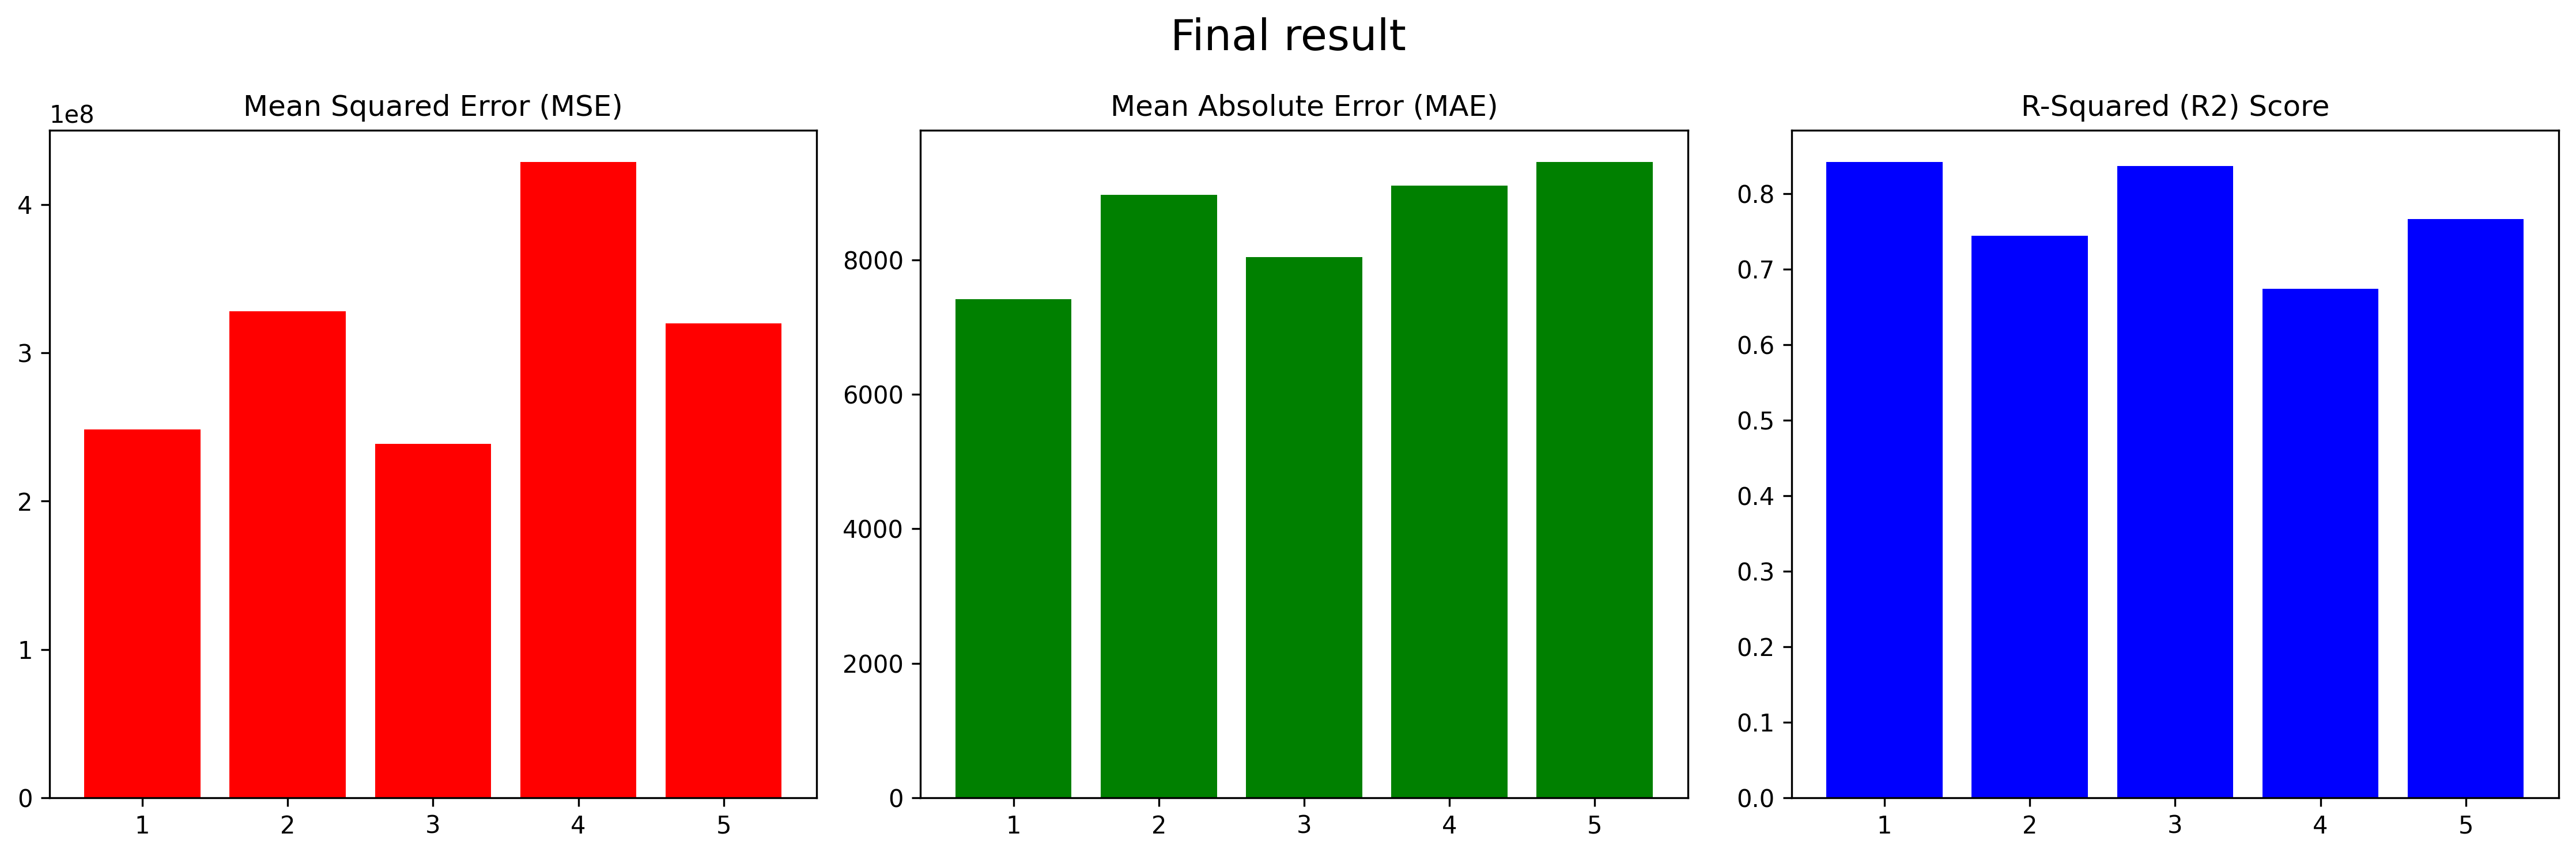

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), dpi=300)
axes[0].bar(range(1, len(mses) + 1), mses, color='red')
axes[0].set_title('Mean Squared Error (MSE)')

axes[1].bar(range(1, len(maes) + 1), maes, color='green')
axes[1].set_title('Mean Absolute Error (MAE)')

axes[2].bar(range(1, len(r2s) + 1), r2s, color='blue')
axes[2].set_title('R-Squared (R2) Score')

fig.suptitle("Final result", fontsize=18)
plt.tight_layout()
plt.show()